In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [48]:
df = pd.read_csv('data.csv')

C:\Users\gray-owl\AppData\Local\Temp\ipykernel_15460\1507164070.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


# Nettoyage

In [49]:
# mettre les nom des colonnes sous forme de xxx-yyy
cols = df.columns.str.lower()
cols = cols.str.replace(r'\W', '-', regex=True)
cols = cols.str.replace(r'à', 'a', regex=True)
cols = cols.str.replace(r'é|è', 'e', regex=True)
df_clean = df.copy()
df_clean.columns = cols
df_clean.columns

Index(['titre', 'localisation', 'prix', 'annee-modele', 'boite-de-vitesses',
       'type-de-carburant', 'kilometrage', 'marque', 'modele',
       'nombre-de-portes', 'origine', 'premiere-main', 'puissance-fiscale',
       'etat', 'abs', 'airbags', 'cd-mp3-bluetooth', 'camera-de-recul',
       'climatisation', 'esp', 'jantes-aluminium', 'limiteur-de-vitesse',
       'ordinateur-de-bord', 'radar-de-recul', 'regulateur-de-vitesse',
       'sieges-cuir', 'systeme-de-navigation-gps', 'toit-ouvrant',
       'verrouillage-centralise-a-distance', 'vitres-electriques'],
      dtype='object')

### Les valeur nulles

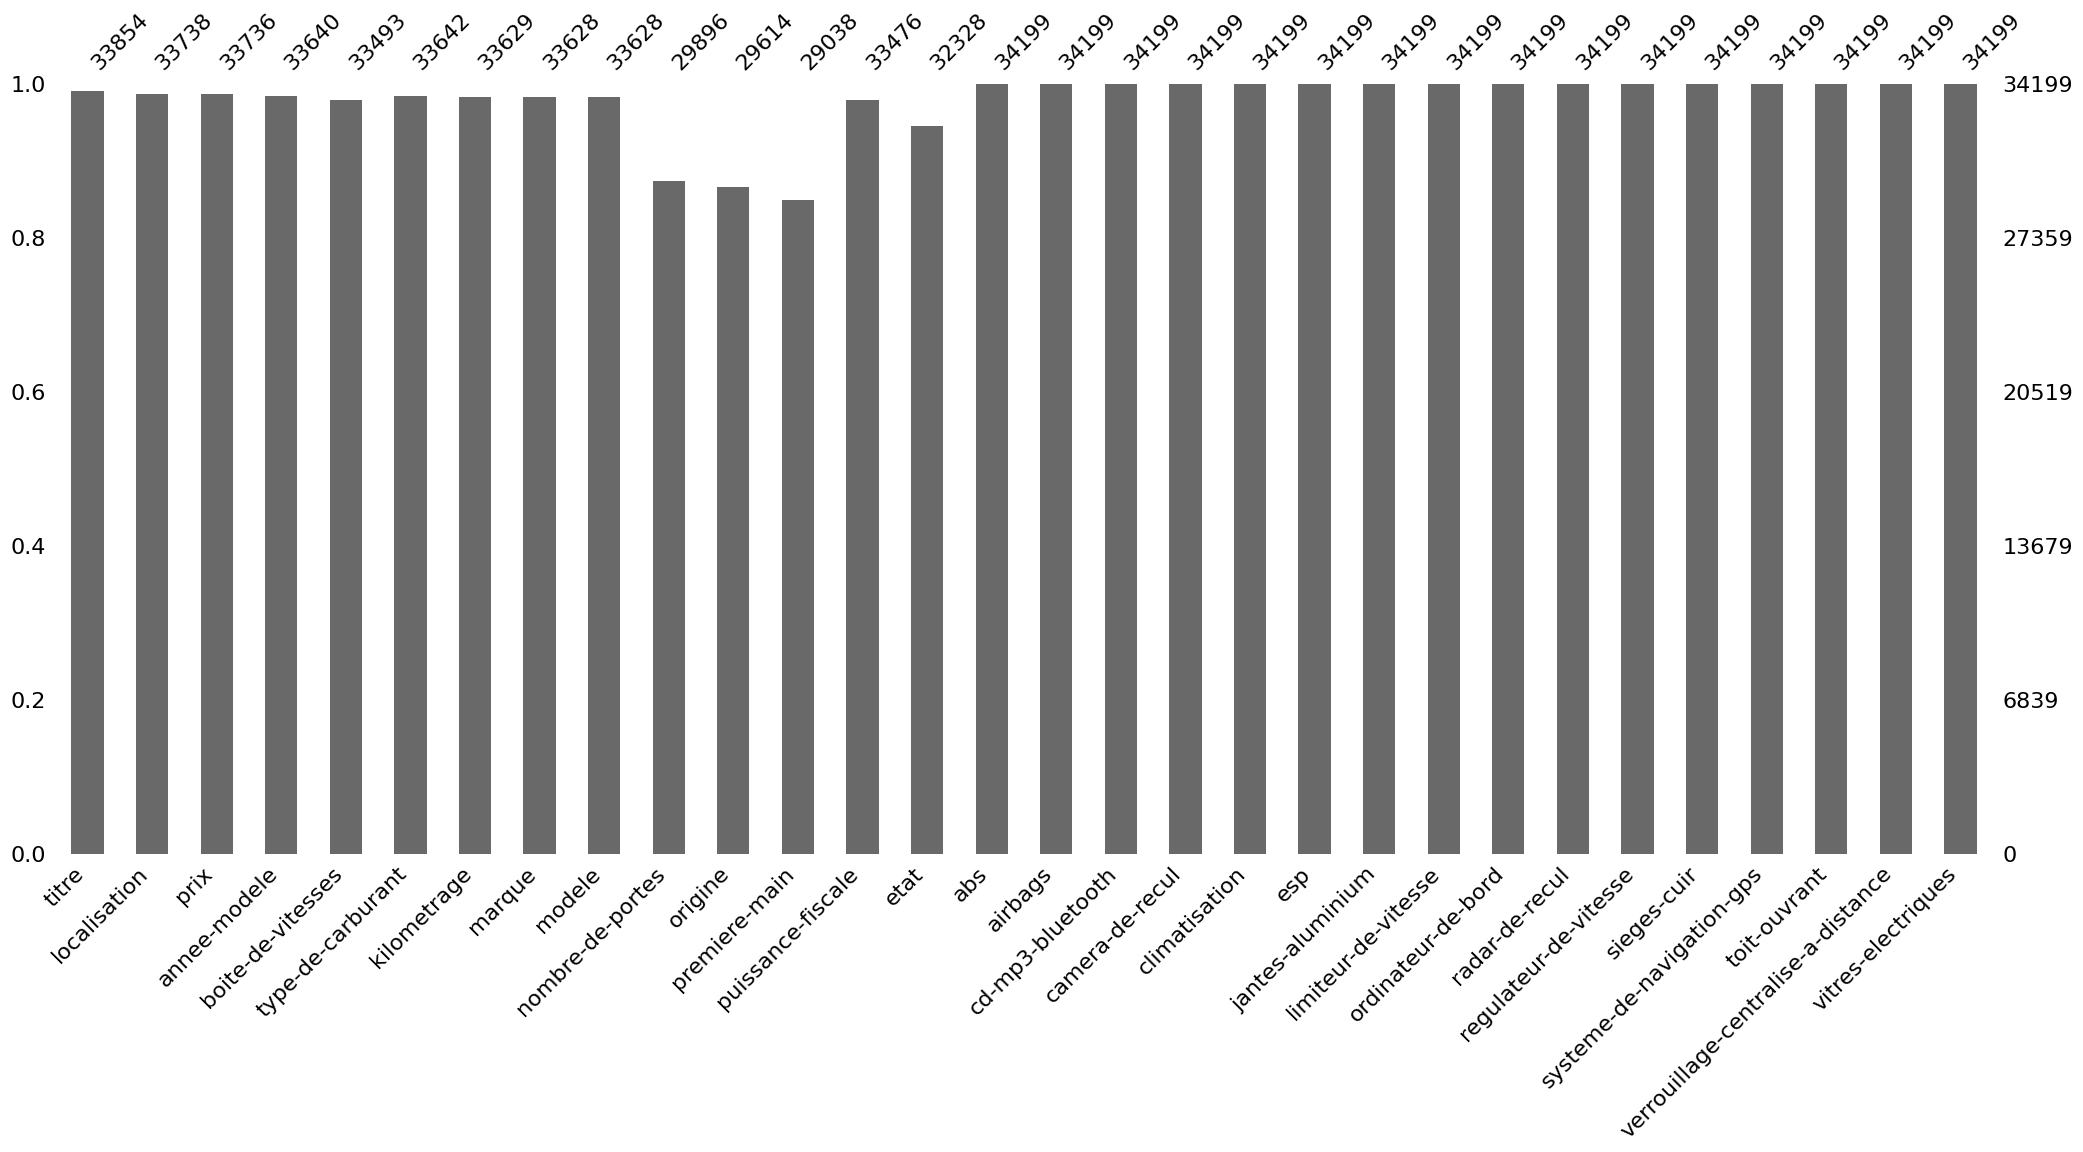

In [50]:
msno.bar(df_clean);

Nombre de valeurs nulles par attribut

In [51]:
nulls_per_attr = df_clean.isna().sum().to_frame().where(lambda x: x > 0).dropna()
nulls_per_attr

,0
titre,345.0
localisation,461.0
prix,463.0
annee-modele,559.0
boite-de-vitesses,706.0
type-de-carburant,557.0
kilometrage,570.0
marque,571.0
modele,571.0
nombre-de-portes,4303.0


Suppression des lignes ayant tous les attributs nulls (à l'exception des attributs booleanes car il sont tous non nulls)

In [52]:
df_clean_all_nulls = df_clean.dropna(subset=nulls_per_attr.index)
print(df_clean_all_nulls.shape)

(25900, 30)


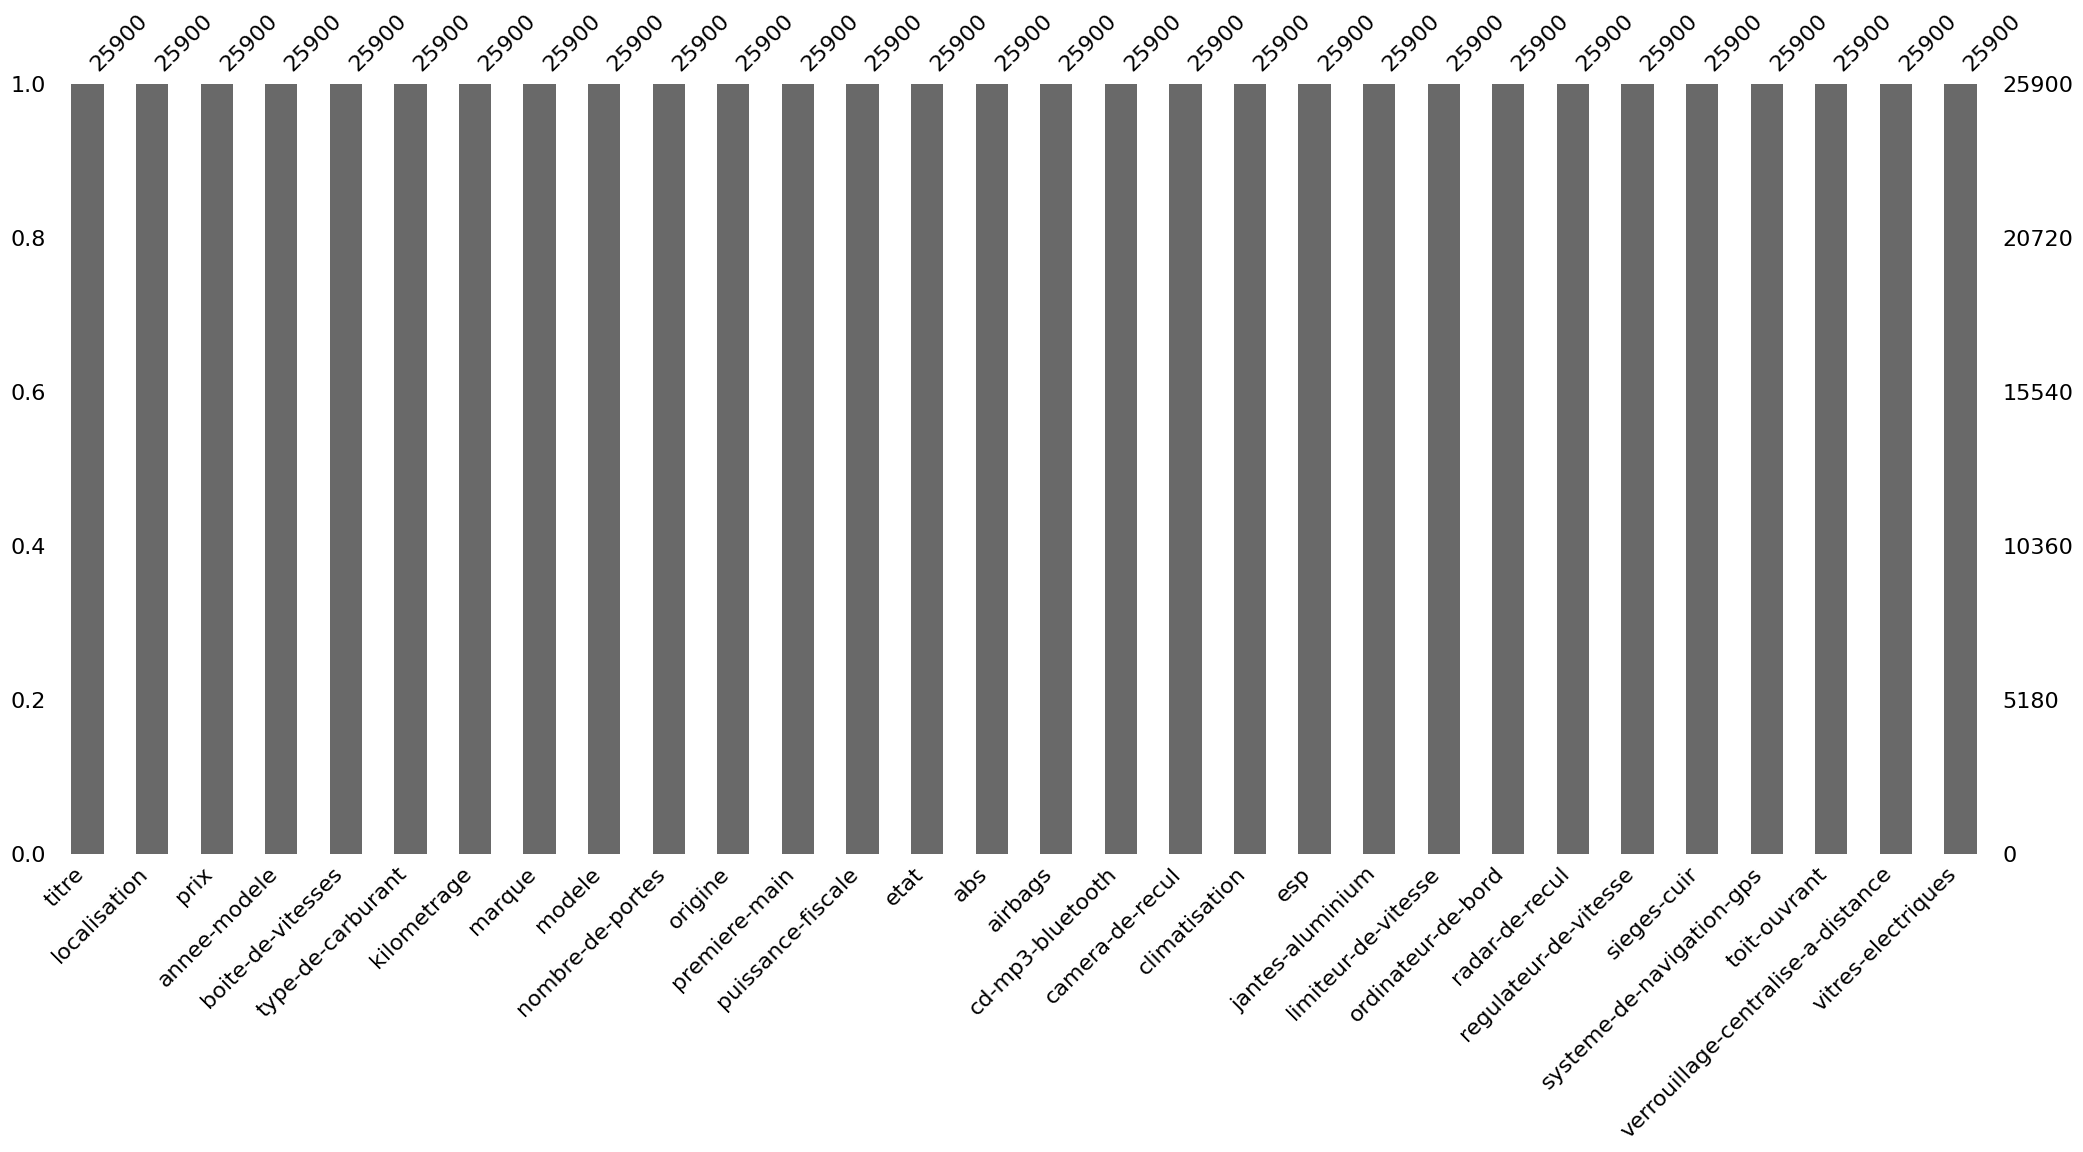

In [53]:
msno.bar(df_clean_all_nulls);

In [54]:
df_clean_all_nulls.isna().sum().to_frame().where(lambda x: x > 0).dropna()

,0


In [55]:
df_clean_all_nulls.sample()

,titre,localisation,prix,annee-modele,boite-de-vitesses,type-de-carburant,kilometrage,marque,modele,nombre-de-portes,...,jantes-aluminium,limiteur-de-vitesse,ordinateur-de-bord,radar-de-recul,regulateur-de-vitesse,sieges-cuir,systeme-de-navigation-gps,toit-ouvrant,verrouillage-centralise-a-distance,vitres-electriques
22391,Opel Corsa Essence Manuelle 2016 à Meknès,"Zerhounia, Meknès",85 000 DH,2016,Manuelle,Essence,100 000 - 109 999,Opel,Corsa,5.0,...,False,False,False,False,False,False,False,False,False,False


Nettoyage de la colonne prix

In [56]:
df_clean_prix = df_clean_all_nulls.copy()
df_clean_prix['prix'] = df_clean_all_nulls['prix'].str.replace(r'\D', '', regex=True)
df_clean_prix['prix'] = pd.to_numeric(df_clean_prix['prix'])
print(df_clean_prix['prix'].sample(2))

469      145000
21448     40000
Name: prix, dtype: int64


Calcul du kilometrage moyen

In [57]:
df_clean_prix.head(2)

,titre,localisation,prix,annee-modele,boite-de-vitesses,type-de-carburant,kilometrage,marque,modele,nombre-de-portes,...,jantes-aluminium,limiteur-de-vitesse,ordinateur-de-bord,radar-de-recul,regulateur-de-vitesse,sieges-cuir,systeme-de-navigation-gps,toit-ouvrant,verrouillage-centralise-a-distance,vitres-electriques
0,kangoo dci,"Toute la ville, Had Soualem",78000,2010,Manuelle,Diesel,250 000 - 299 999,Renault,Kangoo,5.0,...,False,False,False,False,False,False,False,False,True,True
1,Peugeot 208 Diesel Manuelle 2023 à Fès,"Batha, Fès",170000,2023,Manuelle,Diesel,25 000 - 29 999,Peugeot,208,5.0,...,True,True,True,True,True,False,True,False,True,True


Kilometrage

In [58]:

kilometrage_splited = df_clean_prix['kilometrage'].str.replace( r'\s', '', regex=True)
kilometrage_df = kilometrage_splited.str.extract(r'(\d+)-(\d+)')

kilometrage_df[0] = pd.to_numeric(kilometrage_df[0])
kilometrage_df[1] = pd.to_numeric(kilometrage_df[1])

df_clean_kilometrage = df_clean_prix.copy()
df_clean_kilometrage['kilometrage'] = kilometrage_df.mean(axis=1)

df_clean_kilometrage_no_nulls = df_clean_kilometrage.dropna(subset=['kilometrage'])
df_clean_kilometrage_no_nulls.sample()

,titre,localisation,prix,annee-modele,boite-de-vitesses,type-de-carburant,kilometrage,marque,modele,nombre-de-portes,...,jantes-aluminium,limiteur-de-vitesse,ordinateur-de-bord,radar-de-recul,regulateur-de-vitesse,sieges-cuir,systeme-de-navigation-gps,toit-ouvrant,verrouillage-centralise-a-distance,vitres-electriques
5128,Toyota Corolla,"Bab Doukkala, Marrakech",120000,2015,Manuelle,Diesel,224999.5,Toyota,Corolla,5.0,...,True,True,False,True,True,True,True,False,True,True


Convertir la puissance fiscale en un entier

In [59]:
df_clean_puissance = df_clean_kilometrage_no_nulls.copy()

df_clean_puissance['puissance-fiscale'] = df_clean_kilometrage_no_nulls['puissance-fiscale'].str.replace(
    r'\D', '', regex=True)
df_clean_puissance['puissance-fiscale'] = pd.to_numeric(
    df_clean_puissance['puissance-fiscale'])
print(df_clean_puissance['puissance-fiscale'].dtype)

int64


Annee model

In [60]:
def extract_year(val):
    if isinstance(val, str):
        match = re.search(r'\d{4}', val)
        return int(match.group()) if match else np.nan
    elif isinstance(val, float) and not np.isnan(val):
        return int(val)
    elif isinstance(val, int):
        return val
    return np.nan


df_clean_puissance['annee-modele'] = df_clean_puissance['annee-modele'].apply(
    extract_year)

In [61]:
df_clean_annee_modele = df_clean_puissance.copy()
df_clean_annee_modele['annee-modele'] = pd.to_numeric(
    df_clean_puissance['annee-modele'])

Localisation

In [62]:
df_clean_localisation = df_clean_annee_modele.copy()
villes = df_clean_localisation['localisation'].str.extract(r'(.*),(.*)')
villes.columns = ['localisation', 'ville']
villes['ville'] = villes['ville'].str.strip()
arabic_to_french = {
    'الرباط': 'Rabat',
    'الدار البيضاء': 'Casablanca',
    'القنيطرة': 'Kénitra',
    'مراكش': 'Marrakech',
    'فاس': 'Fès',
    'أكادير': 'Agadir',
    'مكناس': 'Meknès',
}
villes['ville'] = villes['ville'].replace(arabic_to_french)

df_clean_localisation['ville'] = villes['ville']

In [63]:
from sklearn.impute import SimpleImputer

# Imputer pour la colonne 'ville'

simpleImputer = SimpleImputer(strategy='most_frequent')
df_clean_localisation['ville'] = simpleImputer.fit_transform(
    df_clean_localisation[['ville']]).ravel()

print(df_clean_localisation['ville'].isna().sum())

0


In [64]:
df_clean_localisation.sample(2)

,titre,localisation,prix,annee-modele,boite-de-vitesses,type-de-carburant,kilometrage,marque,modele,nombre-de-portes,...,limiteur-de-vitesse,ordinateur-de-bord,radar-de-recul,regulateur-de-vitesse,sieges-cuir,systeme-de-navigation-gps,toit-ouvrant,verrouillage-centralise-a-distance,vitres-electriques,ville
5553,Citroen C3 Essence Manuelle 2012 à Marrakech,"Oued Tensift, Marrakech",65000,2012,Manuelle,Essence,104999.5,Citroen,C3,5.0,...,False,False,False,False,False,False,False,False,False,Marrakech
19733,Ford Focus,"Toute la ville, Sidi Bennour",75000,2009,Manuelle,Diesel,194999.5,Ford,Focus,5.0,...,False,False,False,False,False,False,False,False,False,Sidi Bennour


Titre

In [65]:
df_clean_drop = df_clean_localisation.copy()    
df_clean_drop = df_clean_drop.drop(columns=['titre', 'localisation'])

In [66]:
df_clean_drop.isna().sum().to_frame()

,0
prix,0
annee-modele,0
boite-de-vitesses,0
type-de-carburant,0
kilometrage,0
marque,0
modele,0
nombre-de-portes,0
origine,0
premiere-main,0


In [67]:
df_final = df_clean_drop.copy()
df_final.to_csv('data_cleaned.csv', index=False)

# Encoding

In [68]:
df = pd.read_csv('./data_cleaned.csv')

In [69]:
Label_Encoder = LabelEncoder()
One_Hot_Encoder = OneHotEncoder(sparse_output=False)

In [70]:
# On Hot Encoding For 'Boite Vitesse'
One_hot_boite_vitess = One_Hot_Encoder.fit_transform(df[['boite-de-vitesses']])
New_boite_vitess = pd.DataFrame(One_hot_boite_vitess, columns=One_Hot_Encoder.get_feature_names_out([
                                'boite-de-vitesses']), index=df.index)
df = pd.concat([df , New_boite_vitess], axis=1)

In [71]:
# On Hot Encoding For 'Type de Carburant'
One_type_carburant = One_Hot_Encoder.fit_transform(df[['type-de-carburant']])
New_type_carburant = pd.DataFrame(One_type_carburant, columns=One_Hot_Encoder.get_feature_names_out([
                                  'type-de-carburant']), index=df.index)
df = pd.concat([df, New_type_carburant], axis=1)

In [72]:
# Label Encoding For Marque
df['marque'] = Label_Encoder.fit_transform(df['marque'])

In [73]:
# Label Encoding For Modele
df['modele'] = Label_Encoder.fit_transform(df['modele'])

In [74]:
# Label Encoding For Etat

df['etat'] = Label_Encoder.fit_transform(df['etat'])

In [75]:
# On Hot Encoding For 'Origine'
One_Origine = One_Hot_Encoder.fit_transform(df[['origine']])
New_origine = pd.DataFrame(
    One_Origine, columns=One_Hot_Encoder.get_feature_names_out(['origine']), index=df.index)
df = pd.concat([df, New_origine], axis=1)

In [76]:
# On Hot Encoding For 'premiere-main'
One_Premier_Main = One_Hot_Encoder.fit_transform(df[['premiere-main']])
New_Premier_Main = pd.DataFrame(One_Premier_Main, columns=One_Hot_Encoder.get_feature_names_out([
                                'premiere-main']), index=df.index)
df = pd.concat([df, New_Premier_Main], axis=1)

In [77]:
# Transforme Boolean True False ==> 1/0
boolean_columns = [
    'abs',
    'airbags',
    'camera-de-recul',
    'cd-mp3-bluetooth',
    'climatisation',
    'esp',
    'jantes-aluminium',
    'limiteur-de-vitesse',
    'ordinateur-de-bord',
    'radar-de-recul',
    'regulateur-de-vitesse',
    'sieges-cuir',
    'systeme-de-navigation-gps',
    'toit-ouvrant',
    'verrouillage-centralise-a-distance',
    'vitres-electriques',
]
df[boolean_columns] = df[boolean_columns].replace({True: 1, False: 0})
df = df.drop(['boite-de-vitesses', 'type-de-carburant',
             'origine', 'ville', 'premiere-main'], axis=1)
df.head()

C:\Users\gray-owl\AppData\Local\Temp\ipykernel_15460\3274687725.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[boolean_columns] = df[boolean_columns].replace({True: 1, False: 0})


,prix,annee-modele,kilometrage,marque,modele,nombre-de-portes,puissance-fiscale,etat,abs,airbags,...,type-de-carburant_Electrique,type-de-carburant_Essence,type-de-carburant_Hybride,type-de-carburant_LPG,origine_Dédouanée,origine_Importée neuve,origine_Pas encore dédouanée,origine_WW au Maroc,premiere-main_Non,premiere-main_Oui
0,78000,2010,274999.5,52,349,5.0,6,3,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,170000,2023,27499.5,50,24,5.0,5,4,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,62000,2005,324999.5,50,54,5.0,8,6,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,435000,2020,17499.5,38,478,5.0,8,3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,110000,2015,184999.5,12,148,5.0,6,6,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


# Normalisation

In [89]:
Scaler = StandardScaler()

In [90]:
# Colonnes à standardiser
cols_to_standardize = ['annee-modele', 'kilometrage', 'puissance-fiscale']

scaler = StandardScaler()
df[cols_to_standardize] = scaler.fit_transform(df[cols_to_standardize])

In [98]:
df.columns.to_list()

['prix',
 'annee-modele',
 'kilometrage',
 'marque',
 'modele',
 'nombre-de-portes',
 'puissance-fiscale',
 'etat',
 'abs',
 'airbags',
 'cd-mp3-bluetooth',
 'camera-de-recul',
 'climatisation',
 'esp',
 'jantes-aluminium',
 'limiteur-de-vitesse',
 'ordinateur-de-bord',
 'radar-de-recul',
 'regulateur-de-vitesse',
 'sieges-cuir',
 'systeme-de-navigation-gps',
 'toit-ouvrant',
 'verrouillage-centralise-a-distance',
 'vitres-electriques',
 'boite-de-vitesses_Automatique',
 'boite-de-vitesses_Manuelle',
 'type-de-carburant_Diesel',
 'type-de-carburant_Electrique',
 'type-de-carburant_Essence',
 'type-de-carburant_Hybride',
 'type-de-carburant_LPG',
 'origine_Dédouanée',
 'origine_Importée neuve',
 'origine_Pas encore dédouanée',
 'origine_WW au Maroc',
 'premiere-main_Non',
 'premiere-main_Oui']